<a href="https://colab.research.google.com/github/PTharaksa/kaggle/blob/main/spam_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'phishing-email-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5074342%2F8502378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240606%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240606T175827Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D213d333d31fb1ab284a1b16eee0503b12ef3b83d49c92f8b8ab9c6347e0cb0ae8b43b0e259840747ba33c8c678776951ac3912a95d475c6de2b648b42c23c02c39a570136c464275ff7a12a301a4c2b2e579642ec162b40845cb4d37362c07b622c19f59d4769aa069c95a0f2f3cea1315aaa816ad1e58784eca32d3cfd190605475961025286a85f625dbbcdd448808046471bc3d7c905d33ef757e048c7c6657880347971354b327f525d60dcbcc9710988a501698f627590f45a60070181764e36062e1d54de683a9170cf05768ee6ec4e5f98e31a621015dd6bacfbd9ff624b254696627a1cd3b965e6891af8bc7b24c5e9ab3e75315578e6a448937a320'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 80864554 bytes downloaded
Downloaded and uncompressed: phishing-email-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-email-dataset/Enron.csv
/kaggle/input/phishing-email-dataset/Nigerian_Fraud.csv
/kaggle/input/phishing-email-dataset/phishing_email.csv
/kaggle/input/phishing-email-dataset/Nazario.csv
/kaggle/input/phishing-email-dataset/Ling.csv
/kaggle/input/phishing-email-dataset/SpamAssasin.csv
/kaggle/input/phishing-email-dataset/CEAS_08.csv


In [3]:
# import all library
import matplotlib.pyplot as plt
import nltk
import gensim.downloader as api
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Train and Validate data

In [4]:
df_ceas = pd.read_csv('/kaggle/input/phishing-email-dataset/CEAS_08.csv')
df_ceas.head(5)

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [5]:
df_SP = pd.read_csv('/kaggle/input/phishing-email-dataset/SpamAssasin.csv')
df_SP.head(5)

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


In [6]:
print('ceas_08'.upper())
print(df_ceas.info())
print(df_ceas.shape)
print('-------------------------')
print('spamassasin'.upper())
print(df_SP.info())
print(df_SP.shape)

CEAS_08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB
None
(39154, 7)
-------------------------
SPAMASSASIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5809 non-null   object
 1   receiver  5599 non-null   object
 2   date      5809 non-null   object
 3   subject   5793 non-null   object
 4   body      5808 non-null   object
 5   label     5809 non-null   int64 
 6   urls      5809 non-null

In [7]:
print('missing value'.upper())
print('missing value in CEAS_08:')
print(df_ceas.isnull().sum())
print('-----------------------------')
print('missing value in SpamAssasin:')
print(df_SP.isnull().sum())
print('\n')
print('duplicated value'.upper())
print('duplicated value in CEAS_08:')
print(df_ceas.duplicated().sum())
print('-----------------------------')
print('duplicated value in SpamAssasin:')
print(df_SP.duplicated().sum())

MISSING VALUE
missing value in CEAS_08:
sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64
-----------------------------
missing value in SpamAssasin:
sender        0
receiver    210
date          0
subject      16
body          1
label         0
urls          0
dtype: int64


DUPLICATED VALUE
duplicated value in CEAS_08:
0
-----------------------------
duplicated value in SpamAssasin:
0


In [8]:
percent_ceas = round(df_ceas['subject'].isnull().sum()/df_ceas.shape[0]*100, 2)
percent_sp = round(df_SP['subject'].isnull().sum()/df_SP.shape[0]*100, 2)

In [9]:
# calculate the % of missing value and drop it
print(f'% missing value in CEA_08: {percent_ceas} %')
print(f'% missing value in SpamAssasin: {percent_sp} %')

print('\n')

print(f'CEAS_08 shape: {df_ceas.shape}')
print(f'SpamAssasin shape: {df_SP.shape}')
print('---------------------------------------')

df_ceas = df_ceas.dropna()
df_SP = df_SP.dropna()

print(f'CEAS_08 shape: {df_ceas.shape}')
print(f'SpamAssasin shape: {df_SP.shape}')

% missing value in CEA_08: 0.07 %
% missing value in SpamAssasin: 0.28 %


CEAS_08 shape: (39154, 7)
SpamAssasin shape: (5809, 7)
---------------------------------------
CEAS_08 shape: (38669, 7)
SpamAssasin shape: (5582, 7)


In [10]:
# create sub-dataset on only subject, body and label

# sub-dataset
df_ceas = df_ceas[['subject', 'body', 'label']]
df_SP = df_SP[['subject', 'body', 'label']]

# concatinate CEA_08 and SpamAssasin
df_mail = pd.concat([df_ceas,df_SP])



(array([20766.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23485.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

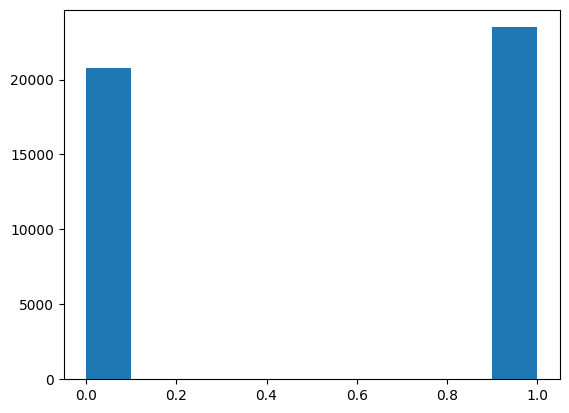

In [11]:
# plot histogram (label distribution)
plt.hist(data=df_mail, x='label')

# Cleaning

In [12]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# remove punctiation and stopword
def clean_data(df):
    punct = '/\."\',!?+=-*#$%@><'
    stops = set(stopwords.words('english'))
    word_tokens = word_tokenize(df)
    filtered_text = [word for word in word_tokens if word.lower() not in punct and word.lower() not in punct and word.strip()]
    return ' '.join(filtered_text)

In [14]:
# before
df_mail.head(5)

,subject,body,label
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [15]:
# apply function
df_mail['subject'] = df_mail['subject'].apply(clean_data)
df_mail['body'] = df_mail['body'].apply(clean_data)

In [16]:
# after
df_mail.head(5)

,subject,body,label
0,Never agree to be a loser,Buck up your troubles caused by small dimensio...,1
1,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1
2,CNN.com Daily Top 10,+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Re : svn commit : r619753 in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http : //7i...,1


# Data Modeling

In [17]:
# load pre-trained GloVe vectors
model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [18]:
# tokenize sentences and convert to vectors
def tokenize_and_vectorize(sentence):
    tokenized_sentence = word_tokenize(sentence.lower())
    return [model[word] for word in tokenized_sentence if word in model]

In [19]:
# apply function
df_mail['sub_vector'] = df_mail['subject'].apply(tokenize_and_vectorize)
df_mail['body_vector'] = df_mail['body'].apply(tokenize_and_vectorize)

# Pad sequences to ensure equal length
max_length = 50  # Define the maximum length for padding
padded_vectors1 = pad_sequences(df_mail['sub_vector'].tolist(), maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)
padded_vectors2 = pad_sequences(df_mail['body_vector'].tolist(), maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)


In [20]:
X = padded_vectors1, padded_vectors2
y = df_mail['label'].values

# concatenate padded vectors along the last axis
padded_vectors_combined = np.concatenate((padded_vectors1, padded_vectors2), axis=-1)

# extract features and labels
X = np.array(padded_vectors_combined)
y = df_mail['label'].values

# reshape the features for the classifier
X_reshaped = X.reshape(X.shape[0], -1)

# split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# initialize and train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# make predictions on the test data
y_pred = classifier.predict(X_val)

# evaluate
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

Accuracy: 0.9604564455993673
precision: 0.9604362703165098
recall: 0.9645618556701031
